# Word2Vec custom training

In [8]:
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
import numpy as np
import keras
import keras.layers as layers
from keras.models import Model
import mlflow
import mlflow.tensorflow
from gensim.models import Word2Vec
import gensim
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer  # Import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Import pad_sequences
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D

# Load train and test datasets
df_train = pd.read_csv('stackoverflow_questions_cleaned_train.csv')
df_test = pd.read_csv('stackoverflow_questions_cleaned_test.csv')

# Print available columns in train dataset
print(df_train.columns)


Index(['date', 'title', 'tags', 'score', 'answer_count', 'sentence_bow',
       'sentence_bow_lem', 'sentence_dl', 'sentence_use'],
      dtype='object')


In [9]:
# Number of top tags to consider
number_of_tags = 50

# Create a list of all tags in the training set
all_tags = [tag for tags in df_train['tags'].apply(eval) for tag in tags]

# Limit tags to the top most frequent
top_tags = [tag for tag, count in Counter(all_tags).most_common(number_of_tags)]

# Filter tags to keep only the top tags
df_train['filtered_tags'] = df_train['tags'].apply(lambda tags: [tag for tag in eval(tags) if tag in top_tags])
df_test['filtered_tags'] = df_test['tags'].apply(lambda tags: [tag for tag in eval(tags) if tag in top_tags])

# Remove rows without tags in the training set
df_train = df_train[df_train['filtered_tags'].map(len) > 0]


In [10]:
# Define parameters for the Word2Vec model
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = 240  # Adjust to the length of your sentences

# Prepare the sentences
sentences = df_train['sentence_bow_lem'].to_list()  # Use your specific DataFrame column
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

# Create and train the Word2Vec model
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size, seed=42, workers=1)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

# Prepare the sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=maxlen, padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

# Create the embedding matrix
print("Create Embedding matrix ...")
embedding_matrix = np.zeros((num_words, w2v_size))
i, j = 0, 0

for word, idx in tokenizer.word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

word_rate = np.round(j / i, 4)
print("Word embedding rate: ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

# Create the embedding model
print("Create Embedding model ...")
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=num_words, output_dim=w2v_size, weights=[embedding_matrix], input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

# Generate embeddings for the sentences
X_train = embed_model.predict(x_sentences)
print(X_train.shape)


Build & train Word2Vec model ...
Vocabulary size: 7511
Word2Vec trained
Fit Tokenizer ...
Number of unique words: 7512
Create Embedding matrix ...
Word embedding rate:  1.0
Embedding matrix: (7512, 300)
Create Embedding model ...


/Users/anthonydavid/Documents/Etudes/alternance_ML_engineer/OpenClassrooms/projets/projet_5/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 240, 300)       │     2,253,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,253,600 (8.60 MB)

 Trainable params: 2,253,600 (8.60 MB)

 Non-trainable params: 0 (0.00 B)

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(6304, 300)


In [11]:

# Encode tags with MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=top_tags)
y_train = mlb.fit_transform(df_train['filtered_tags'])
y_test = mlb.transform(df_test['filtered_tags'])

# Ensure the lengths are consistent
assert y_train.shape[0] == X_train.shape[0], "Mismatch in number of training samples after encoding"


In [12]:
def create_model(input_shape, number_of_tags, layer_units=[256], activation='relu'):
    input_text = layers.Input(shape=input_shape)
    
    x = input_text
    for units in layer_units:
        x = layers.Dense(units, activation=activation)(x)
    
    pred = layers.Dense(number_of_tags, activation='sigmoid')(x)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=[keras.metrics.F1Score(average='micro', threshold=None, name="f1_score_micro", dtype=None),
                           keras.metrics.F1Score(average='weighted', threshold=None, name="f1_score_weighted", dtype=None),
                           keras.metrics.MeanIoU(num_classes=number_of_tags),
                           'accuracy'])
    return model


In [13]:
def train_model(model, train_data, train_tags, test_data, test_tags, epochs=10, batch_size=32):
    history = model.fit(train_data,
                        train_tags,
                        validation_data=(test_data, test_tags),
                        epochs=epochs,
                        batch_size=batch_size
                        )
    return history


In [ ]:
# Generate embeddings for the test sentences
x_test_sentences = pad_sequences(tokenizer.texts_to_sequences(df_test['sentence_bow_lem']), maxlen=maxlen, padding='post')
X_test = embed_model.predict(x_test_sentences)

In [19]:
# import mlflow.models

# layer_units = [256, 128]
# epochs = 10
# batch_size = 32

# # Generate embeddings for the test sentences
# x_test_sentences = pad_sequences(tokenizer.texts_to_sequences(df_test['sentence_bow_lem']), maxlen=maxlen, padding='post')
# X_test = embed_model.predict(x_test_sentences)
# assert X_test.shape[0] == df_test.shape[0], "Mismatch in number of testing samples"

# with mlflow.start_run(run_name="Custom_Word2Vec_model") as run:
#     mlflow.log_param("number_of_tags", number_of_tags)
#     mlflow.log_param("layer_units", layer_units)
#     mlflow.log_param("activation", 'relu')
#     mlflow.log_param("epochs", epochs)
#     mlflow.log_param("batch_size", batch_size)

#     model = create_model(input_shape=(w2v_size,), number_of_tags=number_of_tags, layer_units=layer_units)
#     history = train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size)

#     # Example input data
#     example_input = X_train[:5]

#     # Example output data
#     example_output = model.predict(example_input)

#     # Infer the signature
#     signature = mlflow.models.infer_signature(example_input, example_output)

#     # Log the model with the inferred signature
#     mlflow.keras.log_model(model, "model", signature=signature)

#     for metric, values in history.history.items():
#         for epoch, value in enumerate(values):
#             mlflow.log_metric(metric, value, step=epoch)


In [21]:
# Define model parameters
layer_units = [256]  # Example layer units
number_of_layers = len(layer_units)
activation = 'relu'
epochs = 10
batch_size = 32
vector_size = 300  # Matching the Word2Vec vector size

# Set the MLflow experiment
mlflow.set_experiment("stackoverflow_multilabel_classification")

# Start the MLflow run
with mlflow.start_run(run_name="Word2Vec_custom_model") as run:
    # Add a description for the run
    description = f"Training with Word2Vec for multilabel classification with {number_of_layers} dense layers and units {layer_units}"
    mlflow.set_tag("mlflow.note.content", description)

    # Log parameters
    mlflow.log_param("number_of_tags", number_of_tags)
    mlflow.log_param("embedder", "Custom Word2Vec")
    mlflow.log_param("number_of_layers", number_of_layers)
    mlflow.log_param("units_per_layer", layer_units)
    mlflow.log_param("activation", activation)
    mlflow.log_param("output_activation", 'sigmoid')
    mlflow.log_param("optimizer", 'adam')
    mlflow.log_param("loss", 'binary_crossentropy')
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("w2v_model", 'Custom Word2Vec')
    mlflow.log_param("vector_size", vector_size)

    # Create and train the model
    model = create_model(input_shape=(vector_size,), number_of_tags=number_of_tags, layer_units=layer_units)
    history = train_model(model, X_train, y_train, X_test, y_test, epochs=epochs, batch_size=batch_size)

    # Save model weights
    model.save_weights('./custom_w2v_model.weights.h5')
    mlflow.log_artifact('./custom_w2v_model.weights.h5')

    # Log training metrics
    for metric, values in history.history.items():
        for epoch, value in enumerate(values):
            mlflow.log_metric(metric, value, step=epoch)

    # End the MLflow run
    mlflow.end_run()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.0902 - f1_score_micro: 0.0777 - f1_score_weighted: 0.0317 - loss: 0.4229 - mean_io_u_2: 0.4857 - val_accuracy: 0.3597 - val_f1_score_micro: 0.1393 - val_f1_score_weighted: 0.0339 - val_loss: 0.1080 - val_mean_io_u_2: 0.4888
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2027 - f1_score_micro: 0.1667 - f1_score_weighted: 0.0484 - loss: 0.1239 - mean_io_u_2: 0.4857 - val_accuracy: 0.3667 - val_f1_score_micro: 0.1515 - val_f1_score_weighted: 0.0487 - val_loss: 0.1017 - val_mean_io_u_2: 0.4888
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2306 - f1_score_micro: 0.1898 - f1_score_weighted: 0.0770 - loss: 0.1160 - mean_io_u_2: 0.4856 - val_accuracy: 0.3612 - val_f1_score_micro: 0.1693 - val_f1_score_weighted: 0.0696 - val_loss: 0.0949 - val_mean_io_u_2: 0.4888
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2608 - f1_score_micr

In [22]:
# Save model weights
model.save_weights('./custom_w2v_model.weights.h5')


In [23]:
# Load the model weights
model.load_weights('./custom_w2v_model.weights.h5')

# New text data for prediction
new_text = ["How to read a csv file with pandas?",
            "How to read a csv file in python?",
            "What is the best metric for multilabel classification with a neural network?", 
            "What is the capital of Paris?"]

# Encode new texts using Word2Vec
new_text_encoded = pad_sequences(tokenizer.texts_to_sequences(new_text), maxlen=maxlen, padding='post')
new_text_embeddings = embed_model.predict(new_text_encoded)

# Predict
predicts = model.predict(new_text_embeddings, batch_size=32)

# Display predictions
threshold = 0.2  # You can adjust this threshold

# Get the predicted tags
predicted_tags = (predicts > threshold).astype(int)

# Transform predicted tags back to the original form
predicted_tag_names = mlb.inverse_transform(predicted_tags)

for i, text in enumerate(new_text):
    print(f"Question: {text}")
    print(f"Predicted Tags: {predicted_tag_names[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Question: How to read a csv file with pandas?
Predicted Tags: ('python',)
Question: How to read a csv file in python?
Predicted Tags: ('python',)
Question: What is the best metric for multilabel classification with a neural network?
Predicted Tags: ('python',)
Question: What is the capital of Paris?
Predicted Tags: ()


## Visualize embeddings

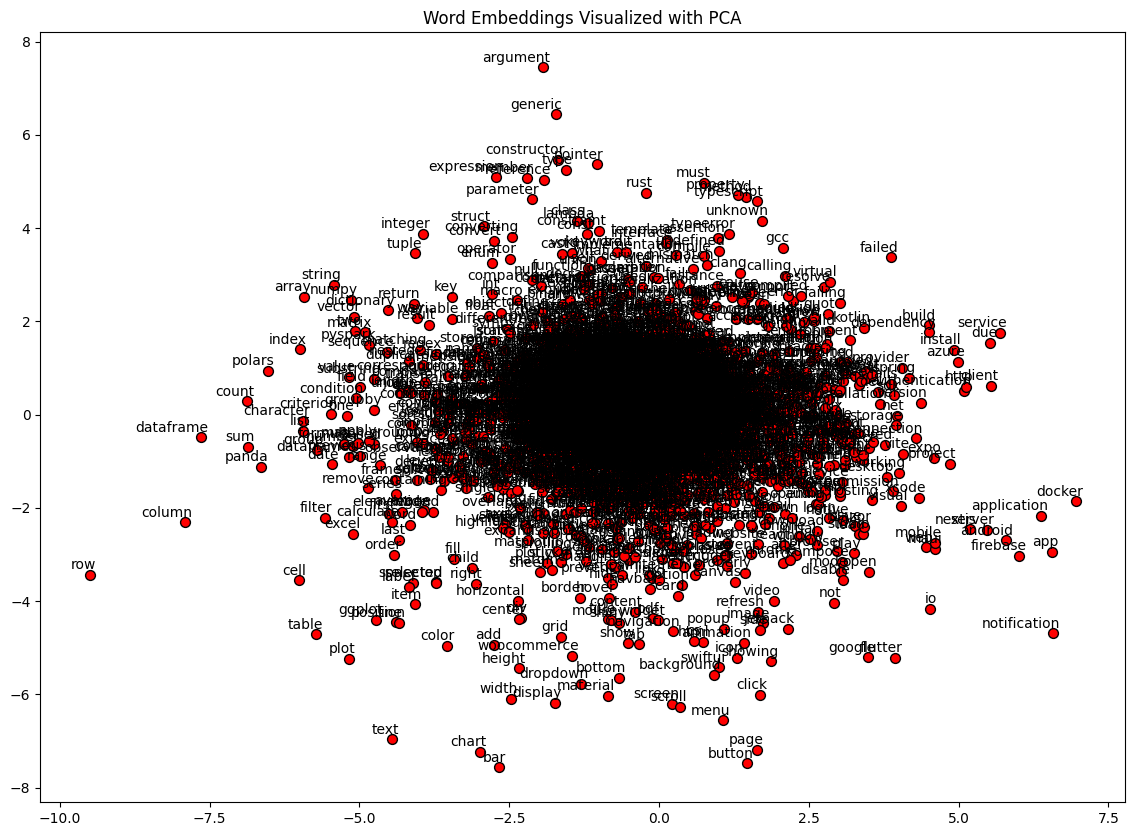

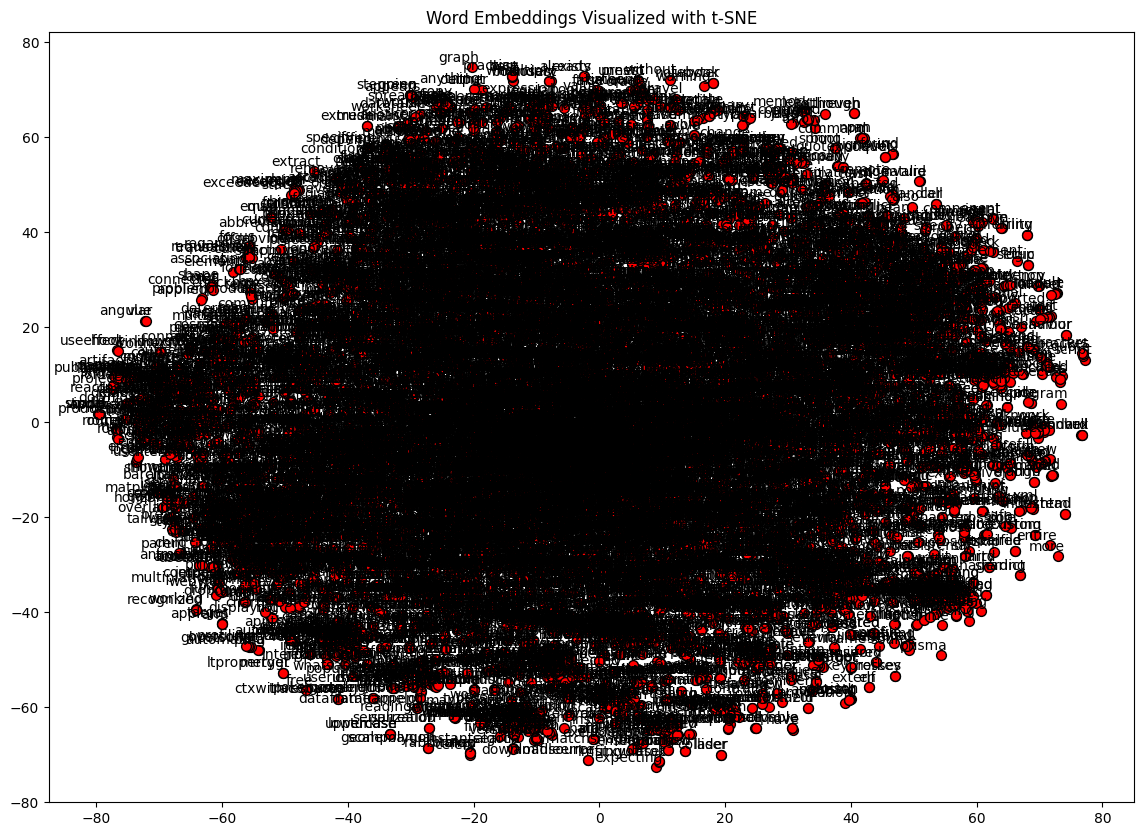

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim

# Assuming you've already trained your Word2Vec model
# w2v_model = gensim.models.Word2Vec(...)

# Extract the word vectors
word_vectors = w2v_model.wv

# Get the list of words (vocabulary)
vocab = list(word_vectors.index_to_key)

# Convert the word vectors to a NumPy array
X = word_vectors[vocab]

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Or, reduce to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

def plot_embeddings(X_reduced, vocab, method_name="PCA"):
    plt.figure(figsize=(14, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], edgecolors='k', c='r', s=50)
    
    # Annotate each point with the corresponding word
    for i, word in enumerate(vocab):
        plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    
    plt.title(f"Word Embeddings Visualized with {method_name}")
    plt.show()

# Plot with PCA
plot_embeddings(X_pca, vocab, method_name="PCA")

# Plot with t-SNE
plot_embeddings(X_tsne, vocab, method_name="t-SNE")

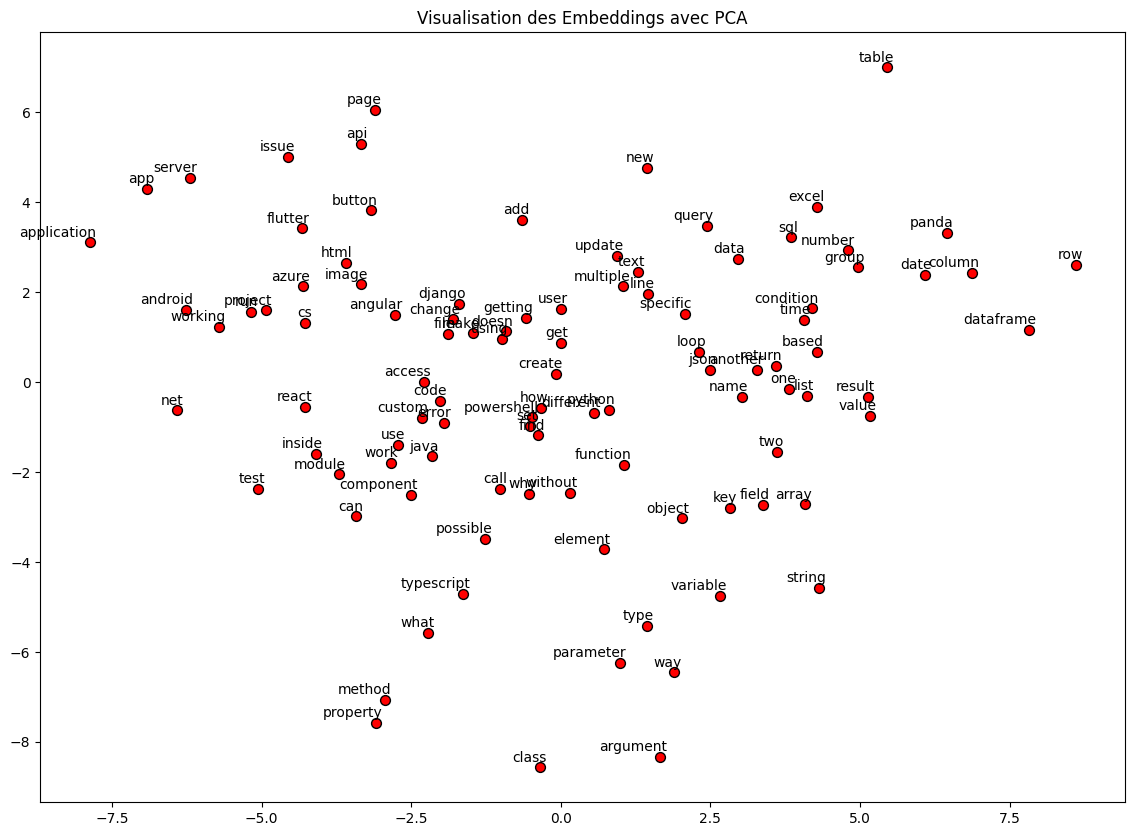

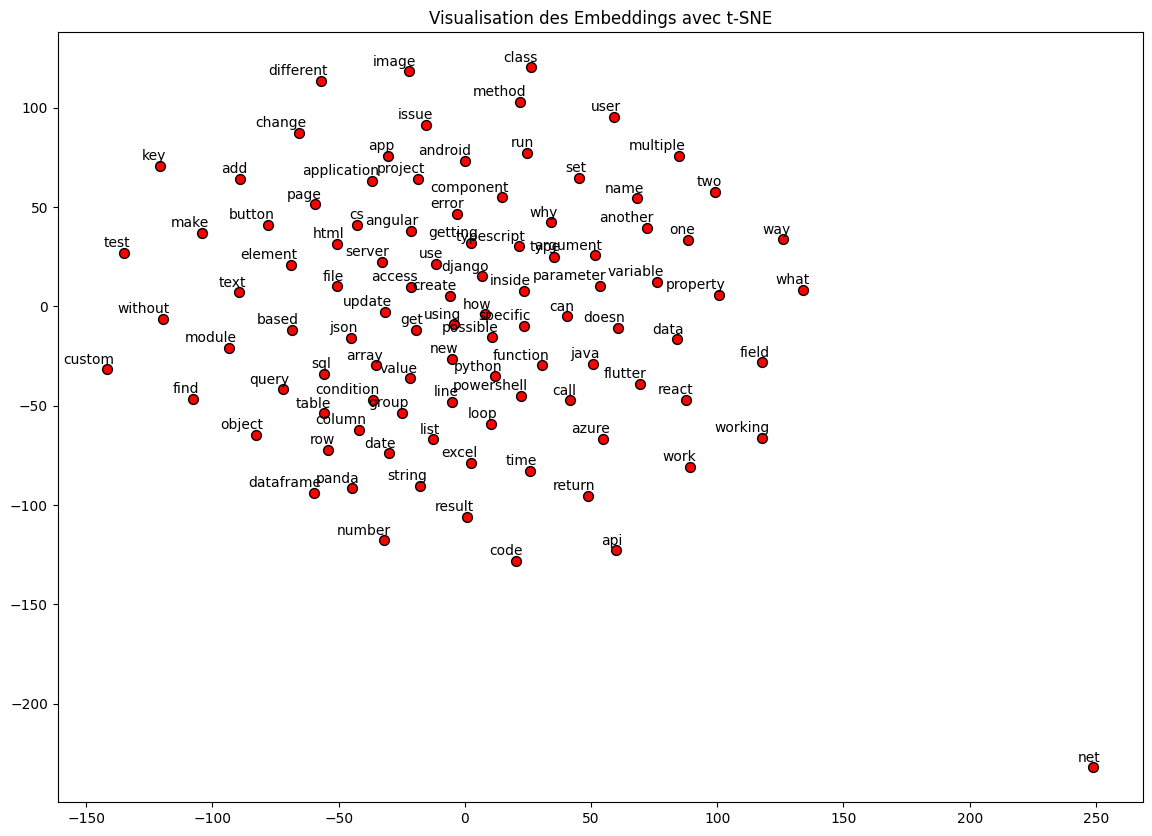

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim

# Nombre de mots à visualiser
n_words = 100  # Par exemple, 100 mots

# Extraire les vecteurs de mots
word_vectors = w2v_model.wv

# Obtenir la liste des mots (vocabulaire)
vocab = list(word_vectors.index_to_key)

# Limiter aux n premiers mots
limited_vocab = vocab[:n_words]

# Convertir les vecteurs de mots en tableau NumPy
X = word_vectors[limited_vocab]

# Réduction de dimension en 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ou, réduction de dimension en 2D avec t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

def plot_embeddings(X_reduced, vocab, method_name="PCA"):
    plt.figure(figsize=(14, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], edgecolors='k', c='r', s=50)
    
    # Annoter chaque point avec le mot correspondant
    for i, word in enumerate(vocab):
        plt.annotate(word, xy=(X_reduced[i, 0], X_reduced[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom')
    
    plt.title(f"Visualisation des Embeddings avec {method_name}")
    plt.show()

# Tracer avec PCA
plot_embeddings(X_pca, limited_vocab, method_name="PCA")

# Tracer avec t-SNE
plot_embeddings(X_tsne, limited_vocab, method_name="t-SNE")